In [1]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [2]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z'}, plus_minus: Optional[dict] = {0: 'z'}) -> QuantumCircuit:
    """For BB84, we take state to be '0', '1', '+', '-' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(1)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[0] == '+':
        qc.h(0)
    if state[0] == '-':
        qc.x(0)
        qc.h(0)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
                
    # apply the Hadamard to obtain + and - state
    for gate, hadamard in plus_minus.items():
        if gate > 1:
            raise ValueError('Provided H Gate number exceeds in the circuit for + or - State')
        else:
            if hadamard == 'h' or hadamard == 'H':
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [3]:
print(create_circuit('1',100))

        ┌───┐┌────────────────┐ ░ ┌─┐
     q: ┤ X ├┤ Delay(100[ns]) ├─░─┤M├
        └───┘└────────────────┘ ░ └╥┘
meas: 1/═══════════════════════════╩═
                                   0 


In [4]:
print(create_circuit('-',100,{0: 'z'},{0: 'h'}))

        ┌───┐┌───┐┌────────────────┐┌───┐ ░ ┌─┐
     q: ┤ X ├┤ H ├┤ Delay(100[ns]) ├┤ H ├─░─┤M├
        └───┘└───┘└────────────────┘└───┘ ░ └╥┘
meas: 1/═════════════════════════════════════╩═
                                             0 


In [6]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","id"])
        
    
    return noise_model

In [7]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['id', 'measure', 'h', 'x', 'delay']>

In [8]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 5000,
          {"delay":True, "measure": True, "gate": False})

<NoiseModel on ['measure', 'delay']>

In [9]:
noise_params = {"T1":193020, "T2":257470} # ibmq_armonk T1: 193.02 , T2:257.47 us
q1_gate_len = 71 # 7.111111111111111e-08
measure_len = 4977.778 # ibmq_armonk  4977.778 

In [10]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for BB84 protocol"""
    """Channel: 1 => |0>+|1>, 2 => |0>+|1> 3 =>|0>+|1>  4=>|0>+|1> """
    
    if channel == '1':
        state = '0'
    elif channel == '2':
        state = '1'
    elif channel == '3':
        state = '+'
    elif channel == '4':
        state = '-'  
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    #print(counts)
    success = 0
    
    if channel == '1':
        if '0' in counts.keys():
            success += counts['0']
        else:
            success +=0
#         if '1' in counts.keys():
#             success += counts['1']
    elif channel == '2':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']
        else:
            success +=0
    elif channel == '3':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']+500
        else:
            success +=500
    elif channel == '4':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']+500
        else:
            success +=500
            
    
    return float(success/shots)

In [11]:
run('2',1000,{"delay": True, "measure": True, "gate": True})

0.963

In [12]:
run('1',1000,{"delay": True, "measure": True, "gate": True})

1.0

In [13]:
run('3',1000,{"delay": True, "measure": True, "gate": True})

1.012

In [14]:
run('4',1000,{"delay": True, "measure": True, "gate": True})

0.952

# Total Probability of Success Graph

# Delay 

In [15]:
import matplotlib.pyplot as plt
state_list=['1','2','3','4']
totalplist=[]
for j in range(20):
    for i in range(len(state_list)):
        delay = np.arange(0,1001000,1000)
        channel = state_list[i]
        apply_error = {"delay":True, "measure": False, "gate": False}
        success = []

        # need to run in multiple loops to get a smoother curve
        for d in range(len(delay)):
            prob = run(channel,int(delay[d]),apply_error)
            success.append(prob)
        totalplist.append(success)

In [16]:
from statistics import mean
a= totalplist
print(*map(mean, zip(*a)))

0.998375 0.99485 0.9948 0.9941 0.9899625 0.9864625 0.9851 0.9841125 0.9795 0.9782 0.9754625 0.9723999999999999 0.9719249999999999 0.969075 0.965625 0.9625375 0.9614125 0.9591 0.954625 0.955725 0.9503 0.946775 0.943175 0.9451625 0.9410625 0.9396125 0.9368 0.9351875 0.9312 0.929725 0.9279000000000001 0.9288625 0.9256 0.9252375 0.918225 0.9169125 0.9155125000000001 0.913525 0.9124125 0.90745 0.9075 0.906725 0.9027625 0.9012625 0.897425 0.898375 0.8943625000000001 0.890175 0.88905 0.8880125 0.8847375 0.8847875000000001 0.881625 0.8765125 0.8795125 0.8775375 0.87455 0.871725 0.869075 0.8687374999999999 0.8655125 0.8658125 0.8613125 0.8599375 0.8609125 0.856125 0.8526 0.8544375 0.851 0.849375 0.8492375 0.846625 0.8437125 0.84385 0.8428249999999999 0.8413875 0.83695 0.83585 0.83295 0.83325 0.8291 0.828975 0.82595 0.8245 0.8230375 0.8220625 0.82245 0.8182 0.817525 0.8154625 0.814975 0.8153 0.8102 0.8109 0.80635 0.8049875 0.8049000000000001 0.8032625 0.8013125 0.7962625 0.7958625 0.79555 0.7950

In [35]:
success=[0.998375,0.99485,0.9948,0.9941,0.9899625,0.9864625,0.9851,0.9841125,0.9795,0.9782,0.9754625,0.9723999999999999,0.9719249999999999,0.969075,0.965625,0.9625375,0.9614125,0.9591,0.954625,0.955725,0.9503,0.946775,0.943175,0.9451625,0.9410625,0.9396125,0.9368,0.9351875,0.9312,0.929725,0.9279000000000001,0.9288625,0.9256,0.9252375,0.918225,0.9169125,0.9155125000000001,0.913525,0.9124125,0.90745,0.9075,0.906725,0.9027625,0.9012625,0.897425,0.898375,0.8943625000000001,0.890175,0.88905,0.8880125,0.8847375,0.8847875000000001,0.881625,0.8765125,0.8795125,0.8775375,0.87455,0.871725,0.869075,0.8687374999999999,0.8655125,0.8658125,0.8613125,0.8599375,0.8609125,0.856125,0.8526,0.8544375,0.851,0.849375,0.8492375,0.846625,0.8437125,0.84385,0.8428249999999999,0.8413875,0.83695,0.83585,0.83295,0.83325,0.8291,0.828975,0.82595,0.8245,0.8230375,0.8220625,0.82245,0.8182,0.817525,0.8154625,0.814975,0.8153,0.8102,0.8109,0.80635,0.8049875,0.8049000000000001,0.8032625,0.8013125,0.7962625,0.7958625,0.79555,0.79505,0.7953625,0.7877625,0.79155,0.78815,0.7881625,0.7849375000000001,0.7860625,0.7822,0.7826500000000001,0.7811,0.7810375,0.7766500000000001,0.773325,0.7738,0.7720125,0.7699875,0.770325,0.76905,0.7662625000000001,0.765925,0.76385,0.762,0.75895,0.7603625,0.7578375,0.75665,0.754325,0.7547,0.7527375,0.7514125,0.750325,0.7476125,0.746775,0.7481625,0.743675,0.746025,0.7432124999999999,0.741225,0.7397875,0.739625,0.7374875,0.7370375,0.735275,0.7366,0.73465,0.7327625,0.7328875,0.7317875,0.7291124999999999,0.729125,0.7263999999999999,0.7246374999999999,0.7233625,0.7231,0.722625,0.7218625,0.72215,0.71715,0.716875,0.7158125,0.7180875,0.7118625,0.7117375,0.711175,0.7098375,0.7089,0.709625,0.7089,0.7051499999999999,0.705825,0.7046125,0.7039124999999999,0.702175,0.7033375,0.6990999999999999,0.6977625,0.6977375,0.697325,0.6970625,0.694775,0.69415,0.6912874999999999,0.69345,0.690275,0.6900375,0.68755,0.6881125,0.6849125,0.6872125,0.683875,0.684075,0.6800125,0.6819625,0.6819875,0.6789375,0.6787875,0.6772625,0.6783,0.6782875,0.6760875000000001,0.6738125,0.6740375,0.6733375,0.6712875,0.6714125,0.6694375,0.6687625,0.66815,0.668075,0.6671875,0.663,0.667725,0.6641625,0.6649125,0.66415,0.6614375,0.6629625,0.661325,0.656375,0.65745,0.6568375,0.6586875,0.655425,0.6557000000000001,0.6521,0.6532625,0.6518125,0.6515875,0.6485375,0.6493375,0.6486500000000001,0.6500375,0.647425,0.6479375,0.6458875000000001,0.6474375,0.64345,0.64455,0.6439125,0.640125,0.6410625,0.6423375,0.641575,0.640575,0.63945,0.6387625,0.637175,0.637775,0.636475,0.6368,0.635825,0.6360875,0.63445,0.632275,0.6330125,0.6321375,0.629575,0.630475,0.630625,0.6282125,0.6279625,0.6256625,0.62725,0.6254,0.62545,0.622925,0.6235375,0.62195,0.623825,0.6220125,0.6219,0.6203375,0.620575,0.6186875,0.6207625,0.6174375,0.6192625,0.6159375,0.6156375,0.617225,0.615875,0.6140125,0.613375,0.6134625,0.612225,0.6119125,0.611575,0.61035,0.6105125,0.6116,0.61,0.6069,0.6088125,0.6082,0.6074875,0.6065125,0.60715,0.6042625,0.6053375,0.604225,0.6038625,0.6051875,0.602425,0.602975,0.6036625,0.6030625,0.601275,0.6002125,0.5987875,0.598375,0.598425,0.5981375,0.5972375,0.59695,0.5978249999999999,0.5956375,0.5952375,0.5954,0.5946625,0.5939375,0.594225,0.5935625,0.5928,0.5924875,0.5921375,0.5915625,0.5905874999999999,0.5897125,0.589,0.591,0.5891875,0.5878875,0.5886625,0.5868125,0.5862875,0.5880875,0.585575,0.5843875,0.585675,0.5851,0.586525,0.5845,0.5831375,0.5838249999999999,0.5832875,0.5825,0.5832999999999999,0.581125,0.582125,0.581475,0.5793375,0.5789624999999999,0.5796,0.5796375,0.5761625,0.5781375,0.577225,0.5765875,0.5777,0.5769124999999999,0.57635,0.5761499999999999,0.5751499999999999,0.5755625,0.5738375,0.57465,0.5777,0.5744625,0.5742375,0.5736749999999999,0.5722125,0.57185,0.571425,0.571775,0.570875,0.5705125,0.5692125,0.570175,0.569125,0.5688,0.5675749999999999,0.5692375,0.56895,0.566525,0.56665,0.5663,0.5677875,0.568175,0.5651875,0.5662,0.5653625,0.565675,0.565025,0.563475,0.5638,0.5656125,0.5633125,0.5621,0.5613125,0.5613375,0.5611875,0.5615375,0.5616375,0.560725,0.5599125,0.55975,0.5596625000000001,0.55845,0.5604875,0.5591375000000001,0.559625,0.559375,0.5566875,0.5581875000000001,0.55815,0.55835,0.5566875,0.55655,0.556575,0.5561625,0.555825,0.5558500000000001,0.5558375,0.555825,0.5542,0.5538625,0.5548,0.5538375,0.553775,0.5528375,0.5549875,0.5525875,0.551,0.552925,0.55305,0.55215,0.5493125,0.551825,0.551125,0.5512375,0.5502375,0.5498000000000001,0.5495625000000001,0.5505375,0.5485,0.5498500000000001,0.55055,0.548025,0.5490375000000001,0.547525,0.5481875,0.5478625,0.5462375,0.5476,0.5472125,0.5446125,0.5462750000000001,0.5472875,0.5464625000000001,0.5452125,0.54645,0.5453,0.5450375000000001,0.5451,0.5453250000000001,0.5454625000000001,0.545525,0.544875,0.54365,0.5432750000000001,0.5425875,0.54155,0.5422125,0.542925,0.541825,0.5419125,0.5423875,0.541925,0.5411875,0.5410875,0.5416625,0.5407125,0.5412750000000001,0.5409375000000001,0.5399875000000001,0.53985,0.5395,0.5403,0.5381375,0.539525,0.5404375,0.53825,0.5386125,0.5381625,0.5388625,0.539025,0.5387125,0.5378125,0.5388875,0.5362625,0.5364,0.53755,0.53715,0.5367125,0.5365875,0.5363625,0.536375,0.5355875,0.5350875,0.5351875,0.534575,0.534075,0.5355125000000001,0.533075,0.5349375000000001,0.5338,0.533725,0.53395,0.5334875,0.534125,0.53335,0.53195,0.5323,0.5322,0.5326375,0.5332875,0.53215,0.53235,0.53105,0.531625,0.5318375,0.532575,0.53185,0.53085,0.5312625,0.530075,0.5316125,0.53055,0.5301375,0.5298875000000001,0.5290875,0.5290125,0.5286,0.5302,0.530475,0.5305125,0.528875,0.5292125,0.5302375,0.52905,0.5285625,0.5284875,0.528775,0.527225,0.5281625,0.5282250000000001,0.5276,0.5266875,0.5285,0.5275,0.526925,0.5271875,0.527525,0.526825,0.5265875,0.526375,0.5271875,0.5263125,0.5261,0.5260125,0.525525,0.5257375,0.5247625,0.524675,0.524975,0.52585,0.52545,0.5238,0.5249625,0.524675,0.52415,0.5242625,0.5240625,0.5234625,0.52425,0.5243875,0.5240875,0.522525,0.5242875,0.523775,0.522875,0.5226125,0.5231125,0.5225375,0.522725,0.5215,0.522375,0.523575,0.5220875,0.5218875000000001,0.521925,0.5222125,0.5215125,0.5214125000000001,0.5212375,0.52075,0.52135,0.5220875,0.5212375,0.5219,0.52145,0.5213,0.5214,0.5209625,0.521225,0.51995,0.5202625,0.5203625000000001,0.52,0.521225,0.519275,0.5197625,0.5195625,0.5192,0.5193625000000001,0.5192875,0.51935,0.519775,0.5186875,0.51885,0.5200625,0.5186875,0.517775,0.51835,0.518,0.5185375,0.5186375,0.518,0.517275,0.517875,0.5179625,0.5176000000000001,0.518,0.517425,0.51695,0.517,0.51725,0.5166125,0.51805,0.516825,0.5166000000000001,0.5169625,0.5170375,0.5162875,0.5156000000000001,0.5170750000000001,0.5166625,0.516175,0.5164375,0.5164125,0.516175,0.5162625,0.5156875,0.5155,0.5161250000000001,0.515975,0.5159625,0.51475,0.5154125,0.515875,0.5160375,0.515425,0.513775,0.515475,0.5151125,0.515175,0.5147,0.514275,0.5150375,0.5143875,0.5143625000000001,0.5147625,0.51475,0.51465,0.5141375,0.514375,0.513475,0.5138,0.5139875,0.5130875,0.5142625,0.51395,0.5136875,0.51335,0.5134625,0.514025,0.5139375,0.5130625,0.51345,0.5132875,0.5126375,0.512725,0.5128375000000001,0.5127625,0.51285,0.5130625,0.5123625,0.51265,0.512,0.5129125,0.5119625,0.512425,0.5121375,0.5121,0.511925,0.5123375,0.5127375,0.511925,0.511825,0.5122,0.5118875,0.5120375,0.511875,0.5112,0.51195,0.5113625,0.51165,0.5108125,0.5109,0.5111625,0.5116625,0.51125,0.5115625,0.5114875,0.5115,0.5115125,0.51045,0.5116125,0.510525,0.5106,0.5109,0.5101875,0.5103875,0.5099375,0.5108125,0.5102125,0.5106125,0.50995,0.5098875,0.5105875,0.51035,0.5104875,0.509625,0.5100375,0.510175,0.5100750000000001,0.5095625,0.5095125,0.5097375,0.510025,0.5099875,0.5090375,0.5096,0.509775,0.509625,0.5098,0.509,0.5091625,0.508975,0.5091375,0.5085875,0.508875,0.509425,0.50875,0.509175,0.50945,0.509,0.508925,0.5092125,0.5084875,0.50815,0.5082875,0.5086625,0.5090125,0.50835,0.5085875,0.5083,0.5084625,0.5081875,0.5086,0.5083625,0.50875,0.50835,0.508525,0.50825,0.50825,0.5075875,0.50835,0.507925,0.507875,0.507025,0.507075,0.507725,0.507475,0.5077125,0.5080125,0.507425,0.5079375,0.5076625,0.507375,0.5075,0.5072625,0.506975,0.5074,0.5073,0.50735,0.507675,0.507175,0.507125,0.5069,0.5065875,0.507075,0.5070625,0.5067,0.507025,0.5069625,0.5063125,0.5063125,0.50695,0.506475,0.5065,0.5074,0.5063375,0.506575,0.506375,0.50625,0.5062375,0.50625,0.5065125,0.5066875,0.5062625,0.5060125,0.5068375,0.5061875,0.506175,0.5059375,0.506225,0.506425,0.5060375,0.5059875,0.5064,0.50545,0.50565,0.50605,0.5057125,0.5057,0.5058125,0.5054125,0.505725,0.50565,0.5057375,0.5054625,0.5060250000000001,0.5053625,0.5061375,0.5055125,0.5057,0.50555,0.5056125,0.5053375,0.50545,0.50515,0.50585,0.505225,0.5054375,0.5051125,0.5053875,0.5056875,0.5056625,0.5047625,0.504875,0.505375,0.505175,0.505175,0.50485,0.50475,0.5051,0.504675,0.5048125,0.5053375,0.504925,0.5054375,0.504525,0.5050375,0.504825,0.504675,0.5049125,0.504875,0.5051375,0.50485,0.504725,0.5050250000000001,0.5044375,0.5045375,0.5043375,0.505,0.5045,0.50395,0.50475,0.5045375,0.5041125,0.5042,0.504275,0.5045625,0.5044375,0.5040625,0.504275,0.5044,0.5043875,0.5042,0.50435,0.504175,0.5042125,0.5041125,0.503925,0.5039625,0.50395,0.5040125,0.5040375,0.5038875,0.5040250000000001,0.50375,0.504125,0.5043375,0.5039,0.50355,0.5039875,0.503975,0.5038875,0.503375,0.5037375,0.503725,0.5040250000000001,0.503675,0.50375,0.5038375,0.5033625,0.5038875,0.5037625,0.5036,0.5032375,0.503575,0.5033375,0.5038125,0.50345,0.5039,0.5036375,0.5032,0.5037375,0.503175,0.50365,0.5035125,0.503425,0.5034375,0.5035125,0.503625,0.5034625,0.5031625,0.5036125,0.502925,0.50305,0.50325,0.50315,0.5033,0.5029875,0.5032625000000001,0.50335,0.502875,0.5029375,0.503125,0.5028375,0.5031375,0.50325,0.5030125,0.5029875,0.5028,0.5029,0.5028125,0.5028875,0.503025,0.5032,0.50265,0.5031,0.5028625,0.5029375,0.5029625,0.5031875,0.50285]


In [ ]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "Error on channel length")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,'ro--',label = "Error on channel length")
ax.legend()

# Delay + Measure

In [17]:
import matplotlib.pyplot as plt
state_list=['1','2','3','4']
totalplist1=[]
for j in range(20):
    for i in range(len(state_list)):
        delay = np.arange(0,1001000,1000)
        channel = state_list[i]
        apply_error = {"delay":True, "measure": True, "gate": False}
        success = []

        # need to run in multiple loops to get a smoother curve
        for d in range(len(delay)):
            prob = run(channel,int(delay[d]),apply_error)
            success.append(prob)
        totalplist1.append(success)

In [18]:
from statistics import mean
a= totalplist1
print(*map(mean, zip(*a)))

0.98815 0.98525 0.9829249999999999 0.9797374999999999 0.9781875 0.9752 0.9706874999999999 0.970375 0.968125 0.9667125 0.964175 0.9630875 0.956925 0.9528875 0.9531375 0.952375 0.9484875 0.9456375 0.9429 0.9404625 0.941175 0.9381875 0.9369999999999999 0.9328 0.93185 0.92965 0.92485 0.9211625 0.921175 0.9168625 0.9168375 0.9163875 0.9124875 0.9119 0.9093 0.9058625 0.9063625 0.903825 0.900625 0.8982625 0.89735 0.8986500000000001 0.8903125000000001 0.8900250000000001 0.8863625 0.8859875 0.8852 0.8793375 0.8792625000000001 0.8771625 0.87935 0.8724875 0.872 0.873025 0.8709875 0.8651875 0.8643125 0.86275 0.8588749999999999 0.8590125 0.8576125 0.85475 0.851075 0.852475 0.8519125 0.848175 0.84725 0.8425374999999999 0.8420375 0.8408125 0.840225 0.836875 0.8329375 0.8356 0.830825 0.8326 0.8282125 0.8287625 0.82585 0.823075 0.8219875 0.8204875 0.8169125 0.8159875 0.8148875 0.8144 0.8159125 0.80885 0.8076375 0.80785 0.803 0.8048375 0.802075 0.8000375 0.796875 0.7962875 0.7980625 0.7966125000000001 0

In [36]:
success1 =[0.98815,0.98525,0.9829249999999999,0.9797374999999999,0.9781875,0.9752,0.9706874999999999,0.970375,0.968125,0.9667125,0.964175,0.9630875,0.956925,0.9528875,0.9531375,0.952375,0.9484875,0.9456375,0.9429,0.9404625,0.941175,0.9381875,0.9369999999999999,0.9328,0.93185,0.92965,0.92485,0.9211625,0.921175,0.9168625,0.9168375,0.9163875,0.9124875,0.9119,0.9093,0.9058625,0.9063625,0.903825,0.900625,0.8982625,0.89735,0.8986500000000001,0.8903125000000001,0.8900250000000001,0.8863625,0.8859875,0.8852,0.8793375,0.8792625000000001,0.8771625,0.87935,0.8724875,0.872,0.873025,0.8709875,0.8651875,0.8643125,0.86275,0.8588749999999999,0.8590125,0.8576125,0.85475,0.851075,0.852475,0.8519125,0.848175,0.84725,0.8425374999999999,0.8420375,0.8408125,0.840225,0.836875,0.8329375,0.8356,0.830825,0.8326,0.8282125,0.8287625,0.82585,0.823075,0.8219875,0.8204875,0.8169125,0.8159875,0.8148875,0.8144,0.8159125,0.80885,0.8076375,0.80785,0.803,0.8048375,0.802075,0.8000375,0.796875,0.7962875,0.7980625,0.7966125000000001,0.79335,0.7949375,0.790225,0.78705,0.783425,0.7902625,0.7847125,0.7813875,0.7799625,0.7797375,0.7793,0.7778875000000001,0.77745,0.7722,0.771675,0.771375,0.7693625000000001,0.7666375,0.7671875,0.764475,0.7643875,0.7609875,0.762575,0.76115,0.757925,0.757925,0.7550250000000001,0.754975,0.7536125,0.7527375000000001,0.7519375,0.74895,0.7483,0.7481625,0.7471625,0.7458875,0.744725,0.7406125,0.741975,0.739475,0.7396125,0.737025,0.7357625,0.7337625,0.73415,0.73095,0.73195,0.7277125,0.7293,0.7298875,0.726025,0.7252,0.7263625,0.725,0.7217875,0.7203499999999999,0.7208749999999999,0.718325,0.7173625,0.7166375,0.712675,0.7137249999999999,0.71095,0.7132375,0.7113125,0.70865,0.7067749999999999,0.7042125,0.7069124999999999,0.706275,0.7043375,0.7038,0.7022375,0.702125,0.70065,0.696725,0.6987125,0.695975,0.696325,0.69465,0.6963625,0.691975,0.69185,0.690025,0.6909375,0.6885625,0.6864875,0.6846625,0.6857875,0.6852,0.682625,0.682775,0.683375,0.681075,0.67855,0.6784375,0.6763,0.6755375,0.677425,0.6753625,0.6752875,0.6748875,0.6708875,0.671875,0.6714,0.6723875,0.66925,0.66785,0.6668000000000001,0.665525,0.6661375,0.663925,0.6655,0.6623,0.6626625,0.6619,0.6590125,0.6620875,0.6602750000000001,0.656375,0.6592,0.6567500000000001,0.65405,0.6550625,0.6526125,0.653575,0.6506875,0.6482625,0.6526625,0.6511125,0.6507375,0.6486125,0.6463125,0.64575,0.6477375,0.646325,0.64505,0.6453375,0.6458875000000001,0.64435,0.6411625,0.6417875,0.6389,0.642225,0.6373625,0.6383,0.6344125,0.6378375000000001,0.6353125000000001,0.6334875,0.63495,0.6362875,0.635625,0.6344375,0.6332875,0.6306875,0.630825,0.6294625,0.6298125,0.6298,0.6286625,0.6272375,0.6254875,0.626175,0.6254875,0.62455,0.62455,0.6251125,0.621925,0.6228,0.62175,0.6208375,0.620575,0.6208125,0.6186125,0.6186,0.618575,0.6180125,0.61615,0.616975,0.6144125,0.6135,0.614375,0.61295,0.614175,0.6132375,0.6113,0.612025,0.610875,0.6103999999999999,0.609175,0.60895,0.6085125,0.6079375,0.6077125,0.60685,0.6079375,0.6051375,0.6039625,0.6028375,0.604275,0.6042375,0.6029375,0.603175,0.6020375,0.6021,0.60125,0.5976125,0.5988,0.5979375,0.600725,0.597325,0.5968625,0.597975,0.59425,0.5973499999999999,0.5943125,0.5973499999999999,0.5952125,0.5952625,0.59425,0.5915874999999999,0.5929,0.5914,0.59265,0.5913499999999999,0.59,0.5927625,0.58895,0.58995,0.5892999999999999,0.5902875,0.5858875,0.58665,0.5852375,0.588125,0.5883125,0.5859375,0.58665,0.5842999999999999,0.5834374999999999,0.5840375,0.583075,0.5841125,0.58215,0.5817125,0.58175,0.5813875,0.5793874999999999,0.5798875,0.5816,0.5795875,0.5797249999999999,0.57765,0.5786,0.578475,0.57705,0.578375,0.5770625,0.576225,0.5768,0.57545,0.57675,0.5757625,0.5741625,0.5737749999999999,0.57405,0.5754374999999999,0.5727,0.57235,0.5723125,0.57145,0.5725375,0.5712375,0.569675,0.5694,0.56995,0.5696375,0.5702375,0.5694875,0.569,0.5692125,0.566875,0.5674125,0.566375,0.567525,0.5678124999999999,0.5673374999999999,0.565275,0.5649875,0.5642375,0.5654625,0.5633,0.5649375,0.562525,0.5632874999999999,0.562675,0.5648375,0.561825,0.562,0.5615625,0.56305,0.563,0.5616625,0.5608,0.5608375,0.5601125,0.5593125,0.5599,0.5585,0.558825,0.559,0.5594375,0.559525,0.5574250000000001,0.55725,0.5556125000000001,0.5563,0.55655,0.556575,0.5552625,0.555475,0.5554875,0.5566625000000001,0.55575,0.5544375,0.552025,0.554,0.5518125,0.552625,0.5535125000000001,0.552725,0.55295,0.552725,0.551125,0.55155,0.551025,0.55265,0.550075,0.5506,0.54815,0.5505,0.5497125,0.5486,0.550025,0.550775,0.5494375,0.549125,0.548675,0.5484875,0.5483750000000001,0.5476625,0.5470375000000001,0.5473750000000001,0.5470125,0.5458000000000001,0.5461,0.5464,0.546175,0.5452375,0.545025,0.5465,0.5446125,0.5443250000000001,0.5459,0.544775,0.5436625,0.5422125,0.54345,0.5436625,0.543825,0.5433625,0.5435875,0.5425625000000001,0.5427375,0.5422875,0.540725,0.5418375,0.540725,0.541825,0.5408000000000001,0.54005,0.5413250000000001,0.53905,0.540075,0.5405125000000001,0.53925,0.5398625,0.5396375,0.5384625000000001,0.539725,0.5386375,0.5382875,0.5381125,0.53755,0.5375625,0.5377625,0.5368875,0.5366500000000001,0.5375125000000001,0.5374375,0.537575,0.5365,0.5372125,0.5356375,0.5360625,0.535375,0.535025,0.535775,0.5359625,0.5345875,0.5349875000000001,0.5335625,0.53495,0.5359125,0.5342125,0.53385,0.5347125,0.533575,0.5328875000000001,0.5336125,0.5337625,0.5330125,0.5332250000000001,0.532725,0.532725,0.5326375,0.5338,0.5318875000000001,0.531675,0.5320375,0.5309,0.5302125,0.5310125,0.53075,0.5317625,0.5316625,0.5289,0.5306125,0.530025,0.5302375,0.5296375,0.529825,0.5290625,0.5301750000000001,0.5292,0.53005,0.5278125,0.5288125,0.5278,0.5292875,0.528275,0.5283375,0.5285625,0.5276500000000001,0.528375,0.528275,0.5269875,0.5276875,0.5274125000000001,0.5259125,0.5272375,0.526675,0.52685,0.5275375,0.5265625,0.5264875,0.5254,0.5251750000000001,0.5258,0.5259125,0.5252,0.525025,0.5250625,0.525075,0.524625,0.5250875,0.524675,0.5246625,0.523825,0.524275,0.5241875,0.523975,0.5233375,0.5236875,0.5231375,0.52245,0.5235,0.522825,0.5232125,0.5230375,0.5234,0.5235625,0.5227375,0.522675,0.5216000000000001,0.522425,0.5217375,0.522625,0.52285,0.5213,0.5220375,0.5222875,0.52195,0.5213375,0.521225,0.521975,0.520975,0.5212375,0.520825,0.5218875000000001,0.5209125,0.52095,0.521025,0.5203875,0.5206875,0.52085,0.5197875,0.5187125,0.5201,0.519625,0.5197,0.5191250000000001,0.5191250000000001,0.519625,0.5192,0.5194125,0.51845,0.5189375,0.518875,0.5190875,0.518725,0.5177,0.518225,0.5193375,0.5188375000000001,0.5177,0.5175125,0.51735,0.5186125,0.518175,0.5173875,0.5175875,0.5175,0.5170875,0.5175,0.517225,0.5169875,0.5171875,0.5175375,0.516875,0.51685,0.5174125,0.51705,0.5170750000000001,0.5168125,0.51705,0.5155625,0.5165125,0.5159,0.5163125,0.5161625,0.5157625,0.5158375000000001,0.516,0.5158625,0.5159625,0.5153125,0.515325,0.5153875,0.51425,0.514875,0.5154875,0.5150125,0.51595,0.5146875,0.514375,0.5142625,0.5149125,0.5148,0.5144625,0.514875,0.5148875,0.5144625,0.51385,0.5133,0.5137,0.5144125,0.513475,0.514475,0.51375,0.5134875,0.5135625,0.514325,0.5139625,0.5141,0.5132875,0.513625,0.5137,0.513375,0.5130875,0.5125625,0.5137125,0.513,0.5128375000000001,0.5123625,0.5122375,0.5127625,0.5125,0.5126000000000001,0.5115875,0.5120125,0.512275,0.5113875,0.512175,0.5113,0.512525,0.5118875,0.511525,0.51145,0.51185,0.5117,0.5115875,0.5119,0.51175,0.51145,0.511475,0.511625,0.510875,0.5111625,0.5110750000000001,0.5112875,0.510225,0.51075,0.5111625,0.510625,0.510875,0.510725,0.5117375,0.5107625,0.5103375,0.5106875,0.5112875,0.5111875,0.510275,0.5101125,0.5101375,0.5094875,0.5102,0.510325,0.509375,0.510175,0.5099125,0.509575,0.5102125,0.5096,0.5095,0.5092,0.5095625,0.5095375,0.509375,0.5092,0.509875,0.5094875,0.509725,0.50905,0.509675,0.509825,0.5089,0.509175,0.5090625,0.509,0.5094875,0.5093375,0.5092625,0.508975,0.508425,0.5085500000000001,0.50905,0.508675,0.508825,0.50865,0.5088,0.508325,0.508475,0.5083,0.5083,0.5085500000000001,0.50815,0.5077375,0.508025,0.5082125,0.5079875,0.5078375,0.50745,0.507875,0.5084125,0.507525,0.5081,0.508025,0.5079,0.5081625,0.5073375,0.5077625,0.5075625,0.5071125,0.50765,0.507975,0.5074375,0.50725,0.5074375,0.506825,0.507775,0.507475,0.50725,0.5071625,0.5069,0.507125,0.5070375,0.5067625,0.5068625,0.5074125,0.5070125,0.506825,0.507275,0.50725,0.507125,0.5068625,0.5066125,0.5069,0.5069625,0.50635,0.506775,0.5064625,0.506675,0.5064375,0.507,0.5068,0.5061625,0.50605,0.506775,0.5063,0.5056875,0.506225,0.5065375,0.506025,0.5059125,0.5060875,0.505825,0.5062,0.506575,0.505925,0.5061,0.5056125,0.5058875,0.5060250000000001,0.50585,0.5055,0.5056875,0.5065125,0.50555,0.5055625,0.5051875,0.5056,0.5054125,0.5055625,0.505225,0.5051375,0.5051375,0.5055125,0.5054875,0.5056875,0.5051375,0.5055125,0.505575,0.5051,0.5055625,0.5054125,0.5054875,0.5050250000000001,0.50525,0.50485,0.5046375,0.5048375,0.5049125,0.5046625,0.5048625,0.5052,0.5048625,0.5048875,0.5054,0.505075,0.5050250000000001,0.5045875,0.5049875,0.50485,0.50495,0.504825,0.5044,0.5050125,0.504775,0.504525,0.50455,0.5046625,0.50495,0.5047,0.5044625,0.5042625,0.504675,0.5039625,0.5040125,0.504525,0.50435,0.50465,0.5047,0.5043625,0.5036375,0.5039875,0.5047625,0.5048375,0.5041375,0.5043,0.50415,0.504,0.504525,0.504075,0.504425,0.504,0.504075,0.5044,0.504,0.5040375,0.503925,0.50405,0.5036,0.5039875,0.50375,0.5040125,0.503825,0.503775,0.50395,0.5036375,0.503775,0.5037375,0.5037,0.503525,0.503925,0.5033625,0.5032875,0.503675,0.5036375,0.5032375,0.503375,0.503425,0.5033375,0.5038375,0.5035375,0.503575,0.503375,0.5034375,0.5031,0.5035,0.50355,0.50365,0.5034625,0.5034375,0.5036625,0.50275,0.5033,0.5031375,0.5035625,0.503425,0.5033375,0.503525,0.5030125,0.50335,0.503025,0.50315,0.5032625000000001,0.5028375,0.5028625,0.5030125,0.502925,0.5031375,0.503125,0.50315,0.5031,0.503025,0.502975,0.5027875,0.50305,0.50305,0.502725,0.5022625000000001,0.50265,0.503025,0.5030125,0.50285,0.5027625,0.50295,0.5030125,0.5027,0.5025875]



In [ ]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success1,label = "Error on channel length + measurement")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success1,'ro--',label = "Error on channel length + measurement")
ax.legend()

# Delay + gates

In [33]:
import matplotlib.pyplot as plt
state_list=['1','2','3','4']
totalplist2=[]
for j in range(20):
    for i in range(len(state_list)):
        delay = np.arange(0,1001000,1000)
        channel = state_list[i]
        apply_error = {"delay":True, "measure": False, "gate": True}
        success = []

        # need to run in multiple loops to get a smoother curve
        for d in range(len(delay)):
            prob = run(channel,int(delay[d]),apply_error)
            success.append(prob)
        totalplist2.append(success)

In [34]:
from statistics import mean
a= totalplist2
print(*map(mean, zip(*a)))

0.9978625 0.9970875 0.9929 0.9902124999999999 0.9908 0.9878375 0.9832875 0.9829375 0.9793125 0.9762 0.9765125 0.971675 0.970275 0.9689375 0.962775 0.964275 0.959925 0.9577125 0.9531125 0.951875 0.9511499999999999 0.9487375 0.946025 0.942125 0.9397125000000001 0.938575 0.9383875 0.935725 0.9338375 0.9307875 0.9297125 0.9241 0.9241375000000001 0.9198375 0.9216375 0.91835 0.9149875 0.912025 0.9102250000000001 0.9081375 0.9046375 0.9041375 0.9017000000000001 0.9001375 0.8981375 0.896425 0.8940875 0.8923125000000001 0.8909125 0.887375 0.8839625 0.8845000000000001 0.8814 0.878725 0.8783375 0.8748875 0.8719 0.8741 0.86815 0.8667875 0.8652124999999999 0.8649 0.860725 0.86215 0.8595125 0.8572375 0.8548125 0.8533499999999999 0.8509375 0.8529375 0.8459125 0.84895 0.843125 0.8417625 0.8421125 0.84115 0.8383125 0.8377 0.8346375 0.830175 0.8284375 0.829525 0.82495 0.8213875 0.8253874999999999 0.8218375 0.8229875 0.818775 0.8201375 0.8166625 0.8141625 0.8104375 0.8098875 0.8066125 0.8086625000000001 

In [38]:
success2=[0.9978625,0.9970875,0.9929,0.9902124999999999,0.9908,0.9878375,0.9832875,0.9829375,0.9793125,0.9762,0.9765125,0.971675,0.970275,0.9689375,0.962775,0.964275,0.959925,0.9577125,0.9531125,0.951875,0.9511499999999999,0.9487375,0.946025,0.942125,0.9397125000000001,0.938575,0.9383875,0.935725,0.9338375,0.9307875,0.9297125,0.9241,0.9241375000000001,0.9198375,0.9216375,0.91835,0.9149875,0.912025,0.9102250000000001,0.9081375,0.9046375,0.9041375,0.9017000000000001,0.9001375,0.8981375,0.896425,0.8940875,0.8923125000000001,0.8909125,0.887375,0.8839625,0.8845000000000001,0.8814,0.878725,0.8783375,0.8748875,0.8719,0.8741,0.86815,0.8667875,0.8652124999999999,0.8649,0.860725,0.86215,0.8595125,0.8572375,0.8548125,0.8533499999999999,0.8509375,0.8529375,0.8459125,0.84895,0.843125,0.8417625,0.8421125,0.84115,0.8383125,0.8377,0.8346375,0.830175,0.8284375,0.829525,0.82495,0.8213875,0.8253874999999999,0.8218375,0.8229875,0.818775,0.8201375,0.8166625,0.8141625,0.8104375,0.8098875,0.8066125,0.8086625000000001,0.80715,0.80165,0.8035875,0.800175,0.80095,0.7992875,0.796575,0.7947,0.790175,0.79035,0.79025,0.7917125,0.786125,0.7863,0.7837125,0.7810375,0.7838375,0.7813375,0.7783125,0.7768875000000001,0.7764,0.77475,0.7701375,0.7698375000000001,0.7702625,0.7665875,0.766525,0.766625,0.7623625,0.764,0.7617,0.7604375,0.7587125,0.755925,0.75525,0.7543125,0.75335,0.751625,0.749725,0.7504125,0.748625,0.7485125,0.7467125,0.7433625,0.74255,0.7439749999999999,0.7401125,0.7403375,0.7384,0.7362,0.7387625,0.7344375,0.73275,0.7341375,0.7317125,0.7278749999999999,0.7265625,0.7296625,0.72395,0.7257375,0.7246625,0.7221124999999999,0.7212125,0.7218125,0.717075,0.7188,0.7166375,0.7172375,0.715725,0.7150124999999999,0.712425,0.70895,0.7127375,0.7086375,0.7087749999999999,0.7079624999999999,0.706925,0.7064874999999999,0.7031625,0.7047625,0.700975,0.70005,0.6990625,0.698975,0.69885,0.6964125,0.6958875,0.695125,0.690425,0.6909875,0.6925625,0.6904875,0.6889875,0.6870125,0.6868625,0.6880375,0.68595,0.6854375,0.684625,0.6840125,0.68285,0.68025,0.679775,0.6792625,0.67665,0.6766625000000001,0.6783750000000001,0.6738500000000001,0.674825,0.6736,0.6744625,0.6716375,0.670075,0.6692,0.669425,0.6679875000000001,0.6685375,0.6675125000000001,0.6647875,0.6660125,0.6634,0.6633,0.6641375,0.6601375,0.6596,0.6612625,0.65885,0.65835,0.6562125,0.6586,0.6542375,0.6561875,0.6535125,0.6553375,0.651825,0.6513125,0.651375,0.6502375,0.64825,0.6501750000000001,0.64935,0.6474375,0.6445375,0.6427,0.6461,0.6436000000000001,0.642475,0.6439375,0.639825,0.6398875,0.6410625,0.6401375,0.639725,0.6387375,0.63685,0.638375,0.6363625,0.6371625,0.6347125,0.634375,0.6347875000000001,0.6328875,0.6291375,0.6301625,0.63045,0.631825,0.6323375,0.6291,0.626025,0.6279625,0.62605,0.626775,0.6264125,0.624975,0.62285,0.6254125,0.6233125,0.6215375,0.6211625,0.621175,0.6176875,0.6212,0.6207125,0.6205,0.6178375,0.617,0.6166874999999999,0.615175,0.6147,0.614425,0.615675,0.613275,0.6128,0.613425,0.60915,0.6100375,0.6131,0.6107625,0.608975,0.607725,0.606225,0.6073999999999999,0.609175,0.607175,0.603925,0.608075,0.605775,0.6057125,0.604575,0.6046374999999999,0.600975,0.60395,0.6011875,0.60165,0.6003,0.598375,0.5985375,0.5990875,0.598025,0.5982875,0.5991124999999999,0.5969125,0.5963375,0.5955625,0.595975,0.5963875,0.596,0.5935,0.5943875,0.5930875,0.5923499999999999,0.593275,0.5919875,0.589875,0.5905,0.5884,0.5892999999999999,0.5895874999999999,0.5882875,0.5882375,0.58715,0.5884375,0.586425,0.5852125,0.5857125,0.5857625,0.58655,0.5843625,0.58455,0.584375,0.581325,0.58375,0.5826749999999999,0.5820124999999999,0.583,0.5813375,0.581825,0.5800124999999999,0.5804874999999999,0.5811999999999999,0.58045,0.5797625,0.5781125,0.5767875,0.5797,0.577075,0.5764374999999999,0.5762999999999999,0.5771499999999999,0.5730375,0.574875,0.5755125,0.5746625,0.57285,0.5740375,0.5746625,0.573125,0.572375,0.573825,0.5724874999999999,0.5715,0.5726,0.5707,0.568125,0.5694,0.5699625,0.5694125,0.5675749999999999,0.5700875,0.568275,0.568725,0.5696125,0.5680499999999999,0.5672625,0.567775,0.5661375,0.5658,0.5658625,0.5661875,0.565425,0.5645125,0.5652375,0.5644375,0.5639,0.5643625,0.563825,0.562475,0.5633,0.5625875,0.562175,0.562,0.5599500000000001,0.5607125,0.5598125,0.5607125000000001,0.56065,0.5586125,0.559075,0.5587375,0.5577375,0.5591,0.557675,0.558275,0.5578,0.5578125,0.5565125,0.5572,0.5577125,0.5573125,0.5555875,0.5555875,0.554625,0.5543125,0.5543875,0.555075,0.5543125,0.5543625,0.5528375,0.5519375,0.552625,0.5534250000000001,0.5515375,0.55195,0.5510125,0.5522,0.550025,0.5508625,0.5513375,0.550425,0.549625,0.5484,0.5495125000000001,0.5493250000000001,0.5493375,0.548725,0.548425,0.54845,0.5468875,0.5458875,0.5479125,0.5477875,0.5475625000000001,0.5471,0.5460875000000001,0.5468125,0.5459875000000001,0.545825,0.5455,0.5453,0.5442,0.544825,0.5450875000000001,0.5443625,0.5435625000000001,0.5435875,0.5439,0.5435875,0.542825,0.5427375,0.5424125,0.543775,0.5419875000000001,0.541925,0.5424625000000001,0.541575,0.5404625000000001,0.540725,0.5407875,0.5421,0.54085,0.5412625,0.5400875,0.5401,0.5392750000000001,0.53995,0.5394875,0.5376875,0.538375,0.5397125,0.53895,0.538475,0.5378125,0.539025,0.53805,0.5388375,0.5377875,0.5375625,0.5369875000000001,0.5365125000000001,0.536125,0.5359,0.5356125,0.5358375,0.5354875,0.5367875,0.5364,0.53615,0.5351125,0.5354375,0.53505,0.5346,0.53535,0.535725,0.5339875000000001,0.5346125,0.534775,0.5328125,0.532675,0.5323125,0.5321375,0.5327000000000001,0.531425,0.5328625,0.532075,0.5317375,0.532075,0.532075,0.5320375,0.531575,0.5311875,0.531775,0.5314875,0.5296375,0.5312,0.5312250000000001,0.5315,0.5310375,0.529425,0.5304875,0.5300125,0.5296500000000001,0.5290625,0.529375,0.5282,0.5277625,0.5280125,0.5285125,0.5291,0.5282875,0.5285625,0.5288875000000001,0.528,0.5278125,0.527625,0.528,0.5277625,0.5265,0.5281,0.5272125,0.5265,0.527075,0.52675,0.5263,0.5270375,0.5261875,0.5255875,0.5251625,0.5261750000000001,0.5256375,0.5261625,0.5253125,0.525875,0.525425,0.5243375,0.524375,0.5252125,0.524475,0.523975,0.5240625,0.5239,0.5244125000000001,0.5246875,0.52305,0.5238625,0.52425,0.5233625000000001,0.5233,0.5231750000000001,0.5235875,0.5235375,0.5236000000000001,0.5222875,0.522825,0.5224375,0.5226500000000001,0.521425,0.5231750000000001,0.52125,0.521175,0.5214875,0.52155,0.521575,0.5224125000000001,0.520825,0.52135,0.520925,0.5215875,0.5209,0.5202125,0.5208375000000001,0.5213375,0.5211375,0.519925,0.5202,0.5206500000000001,0.51975,0.5201125,0.5202,0.5194625,0.5201,0.5196625,0.52055,0.5198875000000001,0.5192875,0.5187875,0.519875,0.5191250000000001,0.5184875,0.51935,0.518475,0.5178375000000001,0.5179625,0.5181375,0.5192,0.5181875,0.518425,0.5178125,0.5173,0.5178125,0.5184,0.5179,0.5180625,0.5171125,0.5176375,0.51775,0.5171375,0.5169875,0.5175875,0.5165,0.5171875,0.517,0.5173625000000001,0.51685,0.516725,0.51635,0.5162875,0.5161250000000001,0.5171,0.515875,0.5159,0.5161250000000001,0.5156375,0.5164625,0.5163625000000001,0.51535,0.5161,0.5153,0.51615,0.515775,0.515725,0.515575,0.5147125,0.514925,0.5145,0.51405,0.51405,0.514825,0.513775,0.5144125,0.5148125,0.5147,0.51385,0.513625,0.5144375,0.5145625,0.5138625,0.513025,0.513775,0.5138375000000001,0.5139125,0.513175,0.513,0.5133625,0.5134,0.5136125,0.512875,0.5137625,0.5135375,0.512925,0.51345,0.51335,0.5135,0.5125625,0.512775,0.5130875,0.5127,0.512175,0.51235,0.5120375,0.512225,0.51215,0.5116125,0.512275,0.51185,0.5124375,0.5125125,0.5118625,0.5124625,0.5116625,0.5110125,0.512025,0.5114125,0.51215,0.5115375,0.511525,0.5108375,0.5113375,0.5116125,0.5103375,0.5109125,0.5110625,0.511375,0.5111375,0.5109875,0.5110125,0.5101625,0.5102375,0.5109875,0.510025,0.510775,0.510025,0.5107625,0.5105375,0.5107375,0.5102375,0.5106125,0.5101125,0.5101125,0.5104,0.510475,0.5100625,0.5097375,0.509975,0.509925,0.509425,0.5095125,0.5098375,0.509725,0.5096125,0.50935,0.5091375,0.50895,0.50945,0.5092125,0.509125,0.509225,0.5095,0.5095500000000001,0.5097875,0.5091875,0.5094,0.5093375,0.5085500000000001,0.5092625,0.5085125,0.508075,0.50885,0.5091625,0.508425,0.509175,0.508375,0.5086375,0.508625,0.50835,0.5086,0.5079875,0.5089125,0.5079875,0.508525,0.5083,0.5082625,0.5080625,0.50825,0.5081,0.5080125,0.5081375,0.507525,0.507675,0.5077625,0.5075500000000001,0.5077375,0.5076625,0.507475,0.508025,0.5074,0.507525,0.5084375,0.5078,0.5072875,0.5076125,0.5066875,0.5076125,0.5073375,0.5072625,0.5076,0.5067625,0.5075500000000001,0.506875,0.507775,0.5065500000000001,0.5072625,0.5066375,0.5067875000000001,0.5072125,0.50695,0.5068125,0.5066125,0.506475,0.506775,0.506675,0.50725,0.506675,0.5068375,0.5068,0.5061875,0.50675,0.5062,0.5063,0.5068125,0.5057,0.5064625,0.50585,0.506575,0.506275,0.505625,0.50555,0.506125,0.50595,0.5059375,0.5058875,0.5059625,0.5061875,0.5057375,0.5058375,0.505675,0.506075,0.50575,0.5055875,0.5056,0.5058375,0.5055125,0.5055125,0.505725,0.505625,0.5053125,0.5052,0.505425,0.5052875,0.505375,0.505525,0.50545,0.5055625,0.5052625,0.5048875,0.505175,0.5056375,0.50495,0.50505,0.5053875,0.5047875000000001,0.5050125,0.5046875,0.5053875,0.50505,0.5050625,0.5052625,0.5053875,0.5051625,0.50505,0.5046625,0.505325,0.504925,0.504675,0.504875,0.5045875,0.5054625,0.50475,0.5045,0.505075,0.504825,0.50465,0.504425,0.504275,0.5044875,0.5044125,0.5044625,0.504325,0.5042875,0.504525,0.504,0.5039375,0.5039875,0.5044,0.5040125,0.5042125,0.5038,0.503725,0.5042125,0.5040875,0.5042625,0.5039,0.5043125,0.5043125,0.50425,0.504275,0.504475,0.5042125,0.5039,0.50395,0.504275,0.5040625,0.5039875,0.503725,0.503625,0.5039125,0.50405,0.5041,0.504275,0.5039625,0.5035125,0.50385,0.503975,0.50335,0.503875,0.5037,0.5038625,0.50375,0.503625,0.50355,0.5034375,0.5036125,0.503725,0.50345,0.5035625,0.5034375,0.5033,0.5035,0.50345,0.5030875,0.5036125,0.503725,0.503425,0.5033625,0.5035375,0.503475,0.503475,0.5030875,0.5033875,0.5033,0.50355,0.503325,0.5027625,0.5031,0.503125,0.50335,0.503225,0.503575,0.502925,0.5031375,0.502875,0.5032,0.50315,0.502875,0.503,0.5028375,0.503075,0.5029875,0.5032625,0.5030625,0.5027125,0.5029625,0.5027,0.5027,0.50295,0.50265,0.5026625]


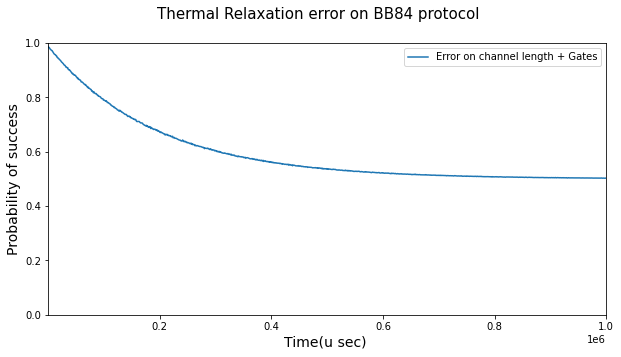

<Figure size 576x360 with 0 Axes>

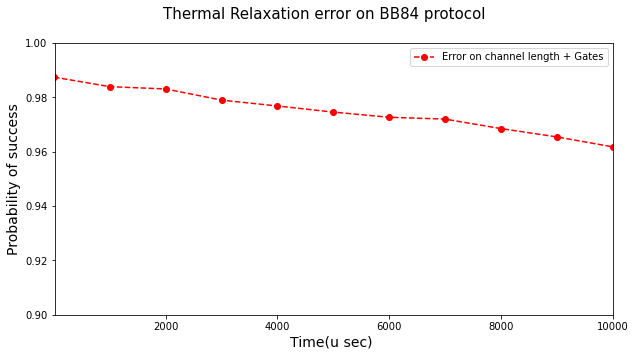

<Figure size 576x360 with 0 Axes>

In [23]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success2,label = "Error on channel length + Gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success2,'ro--',label = "Error on channel length + Gates")
ax.legend()

# Delay + Measure + Gate

In [24]:
import matplotlib.pyplot as plt
state_list=['1','2','3','4']
totalplist3=[]
for j in range(20):
    for i in range(len(state_list)):
        delay = np.arange(0,1001000,1000)
        channel = state_list[i]
        apply_error = {"delay":True, "measure": True, "gate": True}
        success = []

        # need to run in multiple loops to get a smoother curve
        for d in range(len(delay)):
            prob = run(channel,int(delay[d]),apply_error)
            success.append(prob)
        totalplist3.append(success)

In [25]:
from statistics import mean
a= totalplist3
print(*map(mean, zip(*a)))

0.9861875 0.9843999999999999 0.9806625 0.978675 0.9769375 0.9747374999999999 0.9719375 0.9684375 0.9689875 0.965325 0.961125 0.9597875 0.95885 0.9538 0.9507375 0.9497625 0.9475 0.9460875 0.943275 0.93905 0.9378625 0.9377125 0.93785 0.9331 0.9305875 0.9292125 0.92655 0.9241625 0.9216375 0.9181625 0.9187375 0.9154625 0.911325 0.910525 0.9080875 0.9065375 0.9061125 0.9004875 0.8999 0.8988875000000001 0.894325 0.8930250000000001 0.893525 0.89135 0.8866625 0.8843375 0.8855 0.8808625 0.879975 0.8806375 0.875075 0.87315 0.8715125 0.8672625 0.870425 0.8661875 0.86615 0.8629249999999999 0.8608 0.859675 0.8565625 0.853775 0.8513999999999999 0.850625 0.8504375 0.848725 0.84475 0.843475 0.842 0.8428625 0.8406125 0.8357125 0.835325 0.8319124999999999 0.8325875 0.829075 0.8288375 0.8257125 0.8255375 0.8254875 0.823425 0.8182875000000001 0.8176 0.8171375 0.8152875 0.8129 0.812875 0.8107375 0.8101 0.8070125 0.8052 0.804925 0.804225 0.7998375 0.7993250000000001 0.7968375 0.7938625 0.7950875000000001 0.

In [37]:
success3=[0.9861875,0.9843999999999999,0.9806625,0.978675,0.9769375,0.9747374999999999,0.9719375,0.9684375,0.9689875,0.965325,0.961125,0.9597875,0.95885,0.9538,0.9507375,0.9497625,0.9475,0.9460875,0.943275,0.93905,0.9378625,0.9377125,0.93785,0.9331,0.9305875,0.9292125,0.92655,0.9241625,0.9216375,0.9181625,0.9187375,0.9154625,0.911325,0.910525,0.9080875,0.9065375,0.9061125,0.9004875,0.8999,0.8988875000000001,0.894325,0.8930250000000001,0.893525,0.89135,0.8866625,0.8843375,0.8855,0.8808625,0.879975,0.8806375,0.875075,0.87315,0.8715125,0.8672625,0.870425,0.8661875,0.86615,0.8629249999999999,0.8608,0.859675,0.8565625,0.853775,0.8513999999999999,0.850625,0.8504375,0.848725,0.84475,0.843475,0.842,0.8428625,0.8406125,0.8357125,0.835325,0.8319124999999999,0.8325875,0.829075,0.8288375,0.8257125,0.8255375,0.8254875,0.823425,0.8182875000000001,0.8176,0.8171375,0.8152875,0.8129,0.812875,0.8107375,0.8101,0.8070125,0.8052,0.804925,0.804225,0.7998375,0.7993250000000001,0.7968375,0.7938625,0.7950875000000001,0.7937625,0.7921,0.789825,0.787925,0.78765,0.7858,0.7837875,0.7831875,0.7825,0.7799125,0.7784875,0.7756375,0.7755625,0.7714375,0.7717875000000001,0.772975,0.771925,0.7672375,0.7670250000000001,0.7642125,0.7633,0.763975,0.75985,0.7572625000000001,0.7593375,0.7579375,0.7540625,0.7549625,0.7515125,0.7536125,0.7512625,0.749125,0.7492125,0.7451625,0.74425,0.743975,0.7411625,0.74295,0.7410125,0.738475,0.737475,0.73775,0.736275,0.7320125,0.7326875,0.7341375,0.730525,0.72845,0.7286374999999999,0.7287,0.72565,0.7253625,0.7248625,0.7233125,0.722425,0.7197375,0.719125,0.7203375,0.7179875,0.71595,0.7158625,0.7138,0.713175,0.71005,0.7143125,0.709175,0.7087,0.7068375,0.706,0.7045875,0.704325,0.70145,0.7027625,0.7025625,0.6986625,0.6988125,0.70005,0.697675,0.6934625,0.6944875,0.6925875,0.6896125,0.6891375,0.6908125,0.6919375,0.6909,0.687075,0.683375,0.68675,0.68455,0.6851,0.6843375,0.6835625,0.68075,0.679875,0.6794625,0.6759125,0.6772625,0.67695,0.6761,0.67525,0.6748875,0.6729875,0.6715125000000001,0.67005,0.669825,0.667125,0.66765,0.669625,0.66605,0.6654,0.66595,0.663375,0.6624,0.6589625,0.6620625,0.6615375,0.6597500000000001,0.6592125,0.6583125,0.6578125,0.6570375,0.6569,0.6569625,0.653575,0.6538375,0.65255,0.6527875,0.649425,0.6493875,0.649575,0.6479375,0.6474125000000001,0.64575,0.6478375,0.64555,0.6451125,0.6441125,0.6439,0.6415875,0.6408,0.6407625,0.6423875,0.639975,0.64005,0.639225,0.6385500000000001,0.6360625,0.6350750000000001,0.63585,0.633475,0.63505,0.6323625,0.631575,0.6311,0.632425,0.6312375,0.6297125,0.6304625,0.6283875,0.628775,0.6285,0.6277125,0.6258875,0.623675,0.6276,0.62315,0.6224,0.6235375,0.623475,0.6219625,0.6205625,0.620025,0.6220625,0.6195,0.618675,0.618,0.618275,0.6149625,0.6156125,0.6153125,0.61395,0.6129249999999999,0.6143,0.612125,0.6121624999999999,0.6101624999999999,0.6109375,0.6100125,0.608375,0.6112375,0.609075,0.6077875,0.6071,0.6065,0.6071624999999999,0.605825,0.6057125,0.606475,0.6038375,0.6031124999999999,0.604325,0.6031875,0.6026875,0.601325,0.6013125,0.5998249999999999,0.5992375,0.598325,0.59945,0.59905,0.5996,0.596225,0.5989125,0.5954125,0.5968375,0.594675,0.5970875,0.5932499999999999,0.59355,0.5956375,0.5948875,0.5937125,0.5923125,0.591225,0.5904,0.5914125,0.5905874999999999,0.5914125,0.589,0.5886,0.5887749999999999,0.5887625,0.586275,0.588225,0.586475,0.5864125,0.586675,0.5866875,0.5845125,0.58395,0.5842499999999999,0.5823625,0.5828375,0.58095,0.5823875,0.5817375,0.58275,0.58175,0.5809375,0.581125,0.579825,0.5807625,0.5791999999999999,0.578375,0.5796125,0.5792625,0.57985,0.5746875,0.57705,0.57755,0.57765,0.57435,0.5748375,0.5751125,0.574125,0.5740125,0.5742625,0.5741375,0.571975,0.5720875,0.5722625,0.572275,0.5709,0.57105,0.5703125,0.56935,0.57035,0.5702375,0.5690125,0.5678875,0.5678875,0.568375,0.5679625,0.5670499999999999,0.566875,0.5672875,0.5668,0.566225,0.5657,0.5648875,0.565775,0.5640499999999999,0.564475,0.5631625,0.5639375,0.5622375,0.563225,0.562125,0.5620875,0.5629,0.5617625,0.5613375,0.56175,0.5604875,0.5599625,0.5591125,0.5594625,0.56,0.5599500000000001,0.55815,0.5587125000000001,0.5581875000000001,0.5567875,0.5576625000000001,0.557525,0.557175,0.5579875,0.556025,0.5561375000000001,0.55415,0.5566875,0.554875,0.555175,0.5554875,0.5550125,0.5543625,0.554,0.5545125000000001,0.55345,0.5536625000000001,0.5524875,0.5528375,0.5529125,0.5517,0.5514625,0.5518125,0.5516375,0.5504375,0.5520125,0.5496125000000001,0.5511625,0.5479875000000001,0.548975,0.5502125,0.549,0.548775,0.5470625,0.5475125000000001,0.548925,0.5490875000000001,0.5479625,0.5474375,0.5468625,0.54825,0.5474,0.5477625,0.54605,0.5462,0.546975,0.5461875,0.54445,0.5448500000000001,0.5459,0.5439625,0.542925,0.544125,0.5428125,0.5434875,0.5442250000000001,0.5431,0.5428625,0.5433875,0.5423125,0.5435,0.5417125,0.5423375,0.5417875,0.5398375,0.5412625,0.5414875,0.540825,0.5396875,0.5406875,0.5398000000000001,0.5397875,0.5399875000000001,0.539575,0.5371375,0.538725,0.53895,0.5384,0.5386,0.5390375000000001,0.5383,0.5384,0.5385375,0.5369875000000001,0.5375125000000001,0.537375,0.536425,0.53655,0.53705,0.536675,0.5362875,0.53615,0.5361125,0.535325,0.5349125,0.5361750000000001,0.53385,0.5347375,0.5344875,0.5357500000000001,0.5345875,0.533875,0.5345,0.5346125,0.5324375,0.533075,0.5338875000000001,0.5325,0.5321,0.5333125,0.5328,0.5318625,0.532475,0.532675,0.531825,0.5318,0.531525,0.5310875,0.5314375,0.5304125000000001,0.53115,0.531325,0.531,0.5299625,0.5310375,0.5306375,0.5300875,0.53075,0.5292375,0.5296875,0.5293375,0.5302625,0.5300875,0.528375,0.529075,0.5294375,0.5293125,0.52845,0.5280875,0.52845,0.5284,0.52795,0.5283875,0.5258375,0.5276125,0.526975,0.5266,0.527225,0.5263875,0.5270875,0.5269125,0.5270375,0.5270875,0.5253125,0.525725,0.5254375,0.5257125,0.525425,0.5260125,0.52475,0.52475,0.5260875,0.5252125,0.5250625,0.52495,0.523875,0.5238,0.52325,0.5244125000000001,0.5237125,0.5231375,0.5240375,0.5231125,0.523025,0.5243875,0.5231750000000001,0.524075,0.5215,0.522875,0.5227875,0.5225625,0.52335,0.522925,0.523325,0.5222125,0.5221250000000001,0.52215,0.521775,0.5219125,0.522525,0.5212375,0.521225,0.52125,0.52125,0.521025,0.5205625,0.520675,0.5194375,0.521,0.5205875,0.5201,0.5205875,0.519675,0.5195125,0.5193,0.519975,0.51985,0.5193375,0.5191875,0.5205875,0.5191625,0.520425,0.519175,0.519225,0.5195125,0.5187875,0.5185625,0.5183,0.5183625000000001,0.5186125,0.5182875,0.5184375,0.51785,0.5182625,0.51785,0.51725,0.5186875,0.5175125,0.5178625,0.5175,0.517975,0.5169,0.5172,0.5179125,0.516625,0.5173375,0.5167,0.5175875,0.516575,0.5158375000000001,0.515725,0.51635,0.5158875,0.516825,0.5164375,0.5165375,0.5165375,0.5154875,0.51545,0.515775,0.5162,0.51595,0.5157,0.51625,0.5159375,0.5153125000000001,0.5159,0.51425,0.5147625,0.5148125,0.515725,0.5154625,0.5152625,0.51545,0.5148875,0.514625,0.5145875,0.5141875,0.5139,0.515125,0.513625,0.514225,0.514375,0.512975,0.513525,0.51415,0.5136125,0.513425,0.5129125,0.5137375,0.513725,0.51385,0.513325,0.51395,0.513525,0.5131125,0.5128,0.513225,0.5124625,0.5127375,0.5128625,0.5131,0.5122125,0.5127,0.5121375,0.512875,0.5119875,0.5132125,0.5122875,0.51205,0.51185,0.5117625,0.5117625,0.5125,0.5111375,0.51205,0.511975,0.5114625,0.5120125,0.5116875,0.5115125,0.511275,0.51115,0.5117,0.511125,0.5110750000000001,0.5118125,0.5100375,0.511725,0.5112625,0.5108625,0.5107625,0.5112625,0.5108,0.511175,0.51,0.5113375,0.510825,0.5105875,0.510625,0.510475,0.5104375,0.50975,0.51035,0.5102125,0.510925,0.5101875,0.5099375,0.5103,0.5098625,0.5097875,0.509825,0.5094875,0.5102375,0.5100375,0.51025,0.509225,0.5093625,0.5097625,0.5096125,0.508625,0.5097,0.5090625,0.5095375,0.5099375,0.5087375,0.508725,0.5085625,0.5090375,0.50885,0.5085,0.5096875,0.509,0.5086875,0.508675,0.508625,0.5085,0.50875,0.5080625,0.508775,0.508575,0.5082375,0.5082125,0.508275,0.508125,0.5086125,0.508075,0.507975,0.5079875,0.5081375,0.5084625,0.507975,0.5084625,0.5079875,0.5085625,0.5076,0.507925,0.507725,0.5076125,0.5073625,0.5074625,0.507875,0.50785,0.5075375,0.50735,0.5075500000000001,0.5075,0.5070125,0.5071125,0.5072375,0.5073125,0.507025,0.5073125,0.50715,0.5071125,0.5074625,0.5073375,0.5072375,0.5069375,0.5069625,0.5065,0.5072375,0.5069375,0.506475,0.5067375,0.5074625,0.50665,0.5066,0.5066625,0.50625,0.5065500000000001,0.5068,0.50665,0.506225,0.5064375,0.5062375,0.5064375,0.5062375,0.5063125,0.5056125,0.50685,0.5061625,0.5059,0.506175,0.5058625,0.50585,0.505925,0.5060125,0.5059,0.5057125,0.50615,0.5053125,0.5058125,0.5057375,0.5063625,0.5060875,0.5055375,0.506075,0.50525,0.5056375,0.5058875,0.505775,0.50595,0.505875,0.5050875,0.5053625,0.5052375,0.5055125,0.5051625,0.5052875,0.505375,0.505475,0.5051625,0.5052875,0.50585,0.505425,0.5052625,0.5053625,0.50475,0.5051625,0.5048125,0.5049375,0.504725,0.505125,0.5050625,0.504925,0.5043875,0.5045375,0.504775,0.504825,0.5051125,0.50475,0.5046875,0.5046125,0.5048625,0.5048375,0.5046875,0.5042625,0.504425,0.5045625,0.5040875,0.5043375,0.5042625,0.504775,0.5042375,0.5048125,0.50435,0.504475,0.5042375,0.504175,0.50435,0.504175,0.5039875,0.5040625,0.5045375,0.5042,0.504125,0.5038875,0.5037625,0.5041375,0.5040625,0.5038625,0.503825,0.5039875,0.5041375,0.50385,0.5036625,0.5040250000000001,0.503975,0.5039625,0.5038625,0.503775,0.5033625,0.50345,0.503725,0.503625,0.504,0.5039,0.5036125,0.5035625,0.5040125,0.5033125,0.50395,0.5035625,0.5036125,0.5038625,0.5037875,0.503675,0.5034625,0.503475,0.5037625,0.5037,0.503375,0.50325,0.5038375,0.5029875,0.5034375,0.5037125,0.503,0.5034875,0.5030125,0.5034625,0.5032125,0.503225,0.5029875,0.503175,0.5031,0.503325,0.5034625,0.50325,0.5033375,0.503275,0.5034125,0.5034125,0.5028625,0.503325,0.5027375,0.503275,0.5035875,0.503125,0.5027875,0.5028875,0.502975,0.503025,0.503025,0.503,0.5030875,0.5028,0.5032,0.502875,0.5028125,0.50275,0.5027625,0.502725,0.50305,0.5028875,0.502625,0.502575,0.5028375]


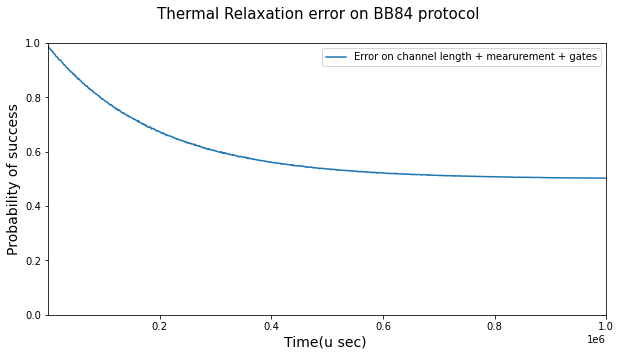

<Figure size 576x360 with 0 Axes>

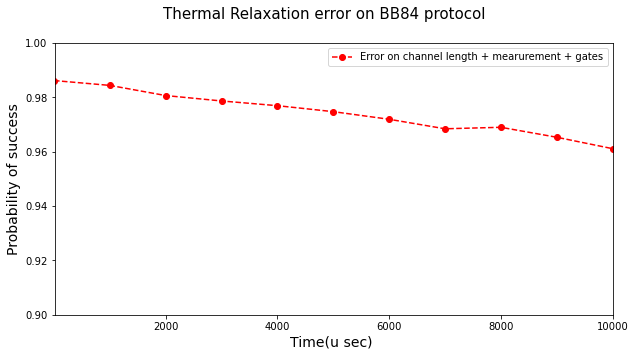

<Figure size 576x360 with 0 Axes>

In [27]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success3,label = "Error on channel length + mearurement + gates")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.9,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success3,'ro--',label = "Error on channel length + mearurement + gates")
ax.legend()

# All Graph Combine

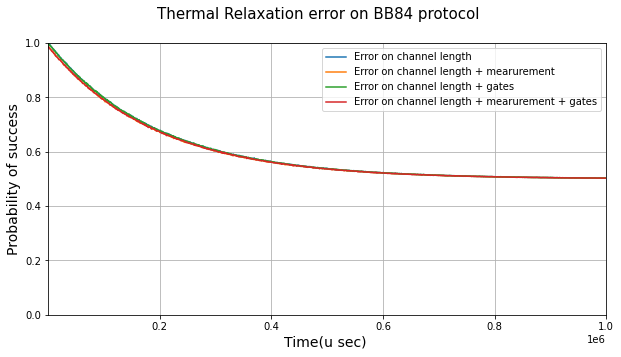

<Figure size 576x360 with 0 Axes>

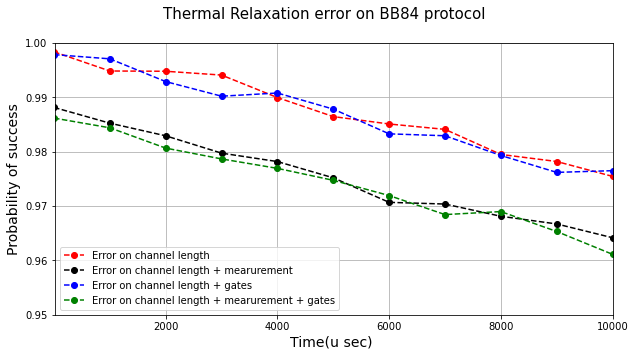

<Figure size 576x360 with 0 Axes>

In [39]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "Error on channel length")
ax.plot(delay,success1,label = "Error on channel length + mearurement")
ax.plot(delay,success2,label = "Error on channel length + gates")
ax.plot(delay,success3,label = "Error on channel length + mearurement + gates")
ax.legend()

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation error on BB84 protocol',fontsize=15)
ax.set_xlim(10, 10000)
ax.set_ylim(0.95,1)
plt.ylabel('Probability of success',fontsize=14)
plt.xlabel('Time(u sec) ',fontsize=14)
plt.grid()
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,'ro--',label = "Error on channel length")
ax.plot(delay,success1,'ko--',label = "Error on channel length + mearurement")
ax.plot(delay,success2,'bo--',label = "Error on channel length + gates")
ax.plot(delay,success3,'go--',label = "Error on channel length + mearurement + gates")
ax.legend()
